<a href="https://colab.research.google.com/github/juramireza/Introducci-n-a-la-inteligencia-artificial/blob/main/CBOW_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Importar librerías

In [15]:
from nltk.corpus import gutenberg # obtener el corpus de la biblia
from string import punctuation # remover la puntiación 
import nltk 
import re
import numpy as np
import pandas as pd
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams 
from keras.layers import *
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential
from nltk.corpus import gutenberg
from string import punctuation
pd.options.display.max_colwidth = 200
import tensorflow as tf
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Input, Dense, Embedding, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
%matplotlib inline

#2.Descarga del proyecto gutenberg, el modelo puntkt y las palabras vacías 

In [4]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#3.Limpieza del corpus documental y tokenización

In [5]:
bible = gutenberg.sents("bible-kjv.txt")
remove_terms = punctuation + '0123456789'

In [6]:
wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
    # Se remueven carácteres especiales y espacios 
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # Se tokeniza el documento
    tokens = wpt.tokenize(doc)
    # Se filtran las palabras vacías 
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # se reconstruye el docuemento tokenizado
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [7]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


#4.Construcción del vocabulario 

In [8]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


#5.Construcción de context_words y target_word

In [9]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [10]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


#6.Construcción del modelo de redes neuronales de CBOW

In [11]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1242500   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12425)             1254925   
                                                                 
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


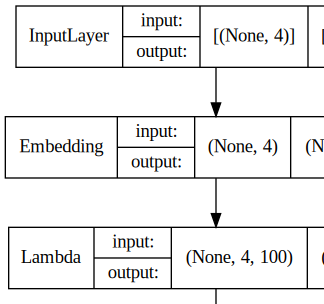

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

#7.Entrenamiento del modelo 

In [13]:
for epoch in range(1, 2):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4304323.513128225



#8.Obtener los embeddings de las palabras

In [14]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,0.548027,0.536858,0.563319,-0.571886,-0.995081,0.620486,0.958802,-0.891449,-0.962193,1.105696,...,-0.893296,-0.812448,0.721232,-0.819662,0.748104,1.068949,-0.846017,0.640654,0.765545,-0.911540
lord,1.090287,0.738525,1.137477,-0.716326,-1.216226,0.713075,0.797588,-1.045836,-1.218183,1.144727,...,-1.096756,-0.905809,0.706046,-1.312984,1.014619,0.987287,-0.745313,0.645334,0.857952,-0.789944
thou,1.014197,1.134574,0.959357,-0.359762,-1.110829,0.352859,0.683742,-0.682392,-0.813862,1.191729,...,-0.620948,-0.620199,1.008694,-0.908294,0.846741,1.099974,-0.839624,0.599624,0.613071,-0.802546
thy,0.642547,0.614721,0.961373,-0.769273,-0.773796,0.575285,1.274230,-0.553037,-0.645885,0.957949,...,-0.895595,-0.459273,0.651339,-0.766996,0.928160,0.995963,-0.583877,0.685638,0.636399,-0.911842
god,0.748166,0.842013,0.397855,-0.365034,-0.708285,0.448927,0.892557,-0.619979,-0.613265,0.426813,...,-0.960678,-0.431184,0.741216,-0.818475,0.823447,0.782347,-0.746370,0.649249,0.666183,-0.681127


#9.Matriz de distancia entre palabras similares

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['wherein', 'houses', 'mountains', 'dwell', 'strength'],
 'famine': ['waste', 'reproach', 'ones', 'slay', 'sore'],
 'god': ['also', 'unto', 'things', 'shall', 'hath'],
 'gospel': ['hope', 'saints', 'hearts', 'must', 'committed'],
 'jesus': ['spirit', 'holy', 'christ', 'saw', 'law'],
 'john': ['peter', 'knew', 'departed', 'new', 'whether'],
 'moses': ['lie', 'believe', 'believed', 'committed', 'gentiles'],
 'noah': ['shammah', 'transgress', 'reverence', 'possessions', 'lightning']}